<center><h1>Deep Metric Learning (DML) Model</h1></center>
Using DML to make an embedding space for our samples. We hvae used siamese network with contrastive loss for DML, then we classify the training examples on the projections of the siemese network.

# 1. Import Requirements

In [1]:
import hashlib

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, QuantileTransformer, PowerTransformer
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import BayesianRidge
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.utils.class_weight import compute_class_weight

from xgboost import XGBClassifier

import tensorflow as tf
from tensorflow.keras import Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, LeakyReLU, Lambda
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping

from joblib import dump, load

2024-10-03 21:24:56.018601: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-03 21:24:56.040437: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-03 21:24:56.064573: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-03 21:24:56.071857: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-03 21:24:56.090988: I tensorflow/core/platform/cpu_feature_guar

# 2. Load the Preprocessed Dataset

In [2]:
# Load the preprocessed training and test datasets
train_data = pd.read_csv('dataset_preprocessed/Processed_Train.csv')
test_data = pd.read_csv('dataset_preprocessed/Processed_Test.csv')

In [3]:
# Separate features and target from the training dataset
X_train = train_data.drop(columns=['target'])
Y_train = train_data['target']
X_test = test_data.drop(columns=['target'])
Y_test = test_data['target']

# 3. Test the Preprocessed Dataset (Optional)

In [27]:
# General info about the datasets
print("\ncombined_train Info:")
print(combined_train.info())

# Check for missing values in both X and Y datasets
print("\nMissing values in combined_train:")
print(combined_train.isna().sum())

# Descriptive statistics of the numerical features
print("\nStatistical Summary of combined_train:")
print(combined_train.describe())


combined_train Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 785133 entries, 0 to 785132
Data columns (total 26 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Column0            785133 non-null  float64
 1   Column1            785133 non-null  float64
 2   Column2            785133 non-null  float64
 3   Column3            785133 non-null  float64
 4   Column4            785133 non-null  float64
 5   Column5            785133 non-null  float64
 6   Column6            785133 non-null  float64
 7   Column7            785133 non-null  float64
 8   Column8            785133 non-null  float64
 9   Column9            785133 non-null  float64
 10  Column10           785133 non-null  int64  
 11  Column11           785133 non-null  int64  
 12  Column12           785133 non-null  int64  
 13  Column13           785133 non-null  int64  
 14  Column14           785133 non-null  float64
 15  Column15           785133 non

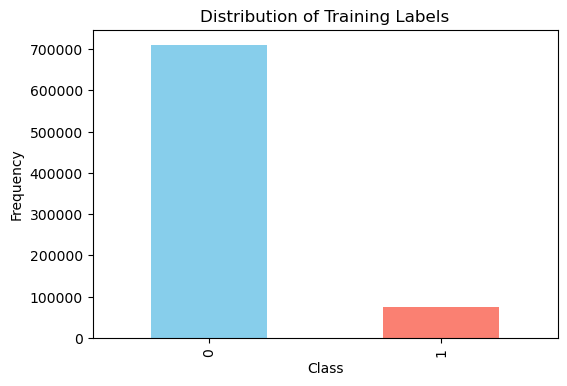

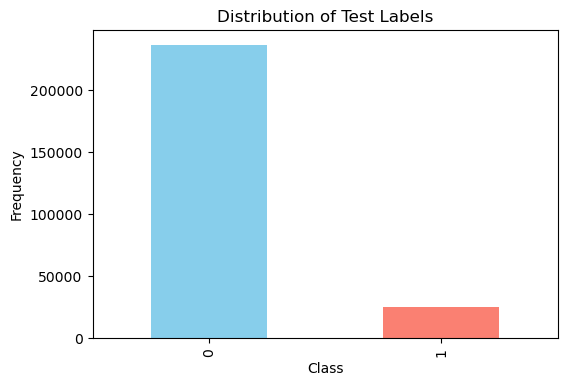

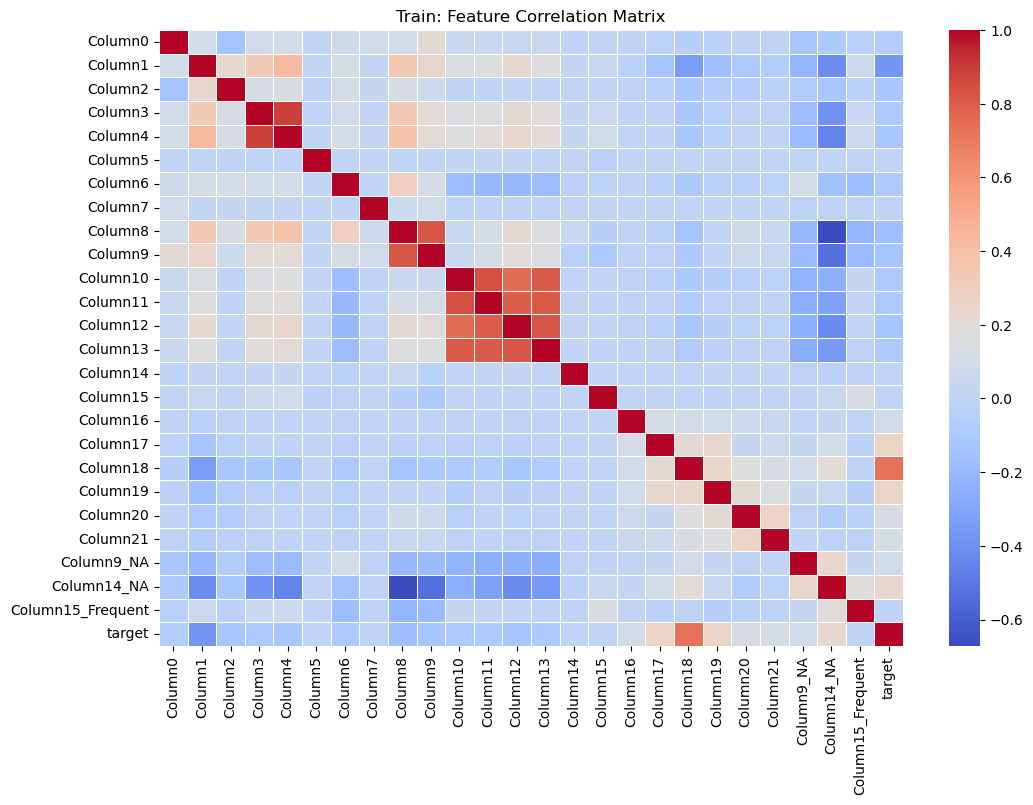

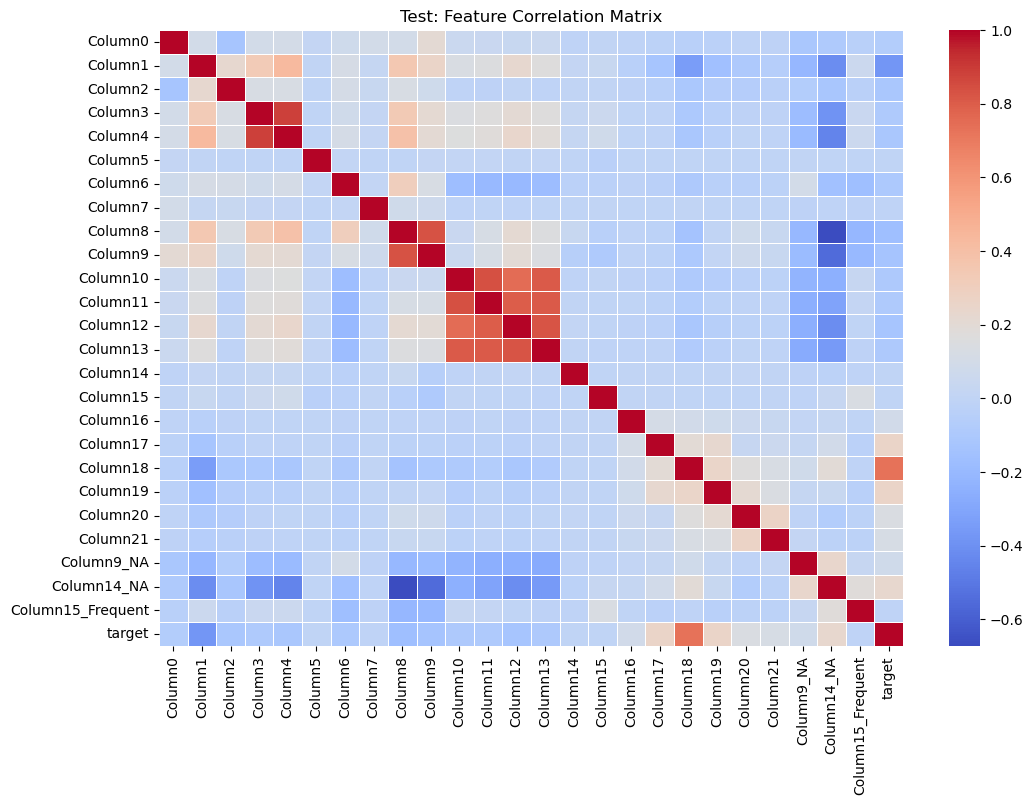

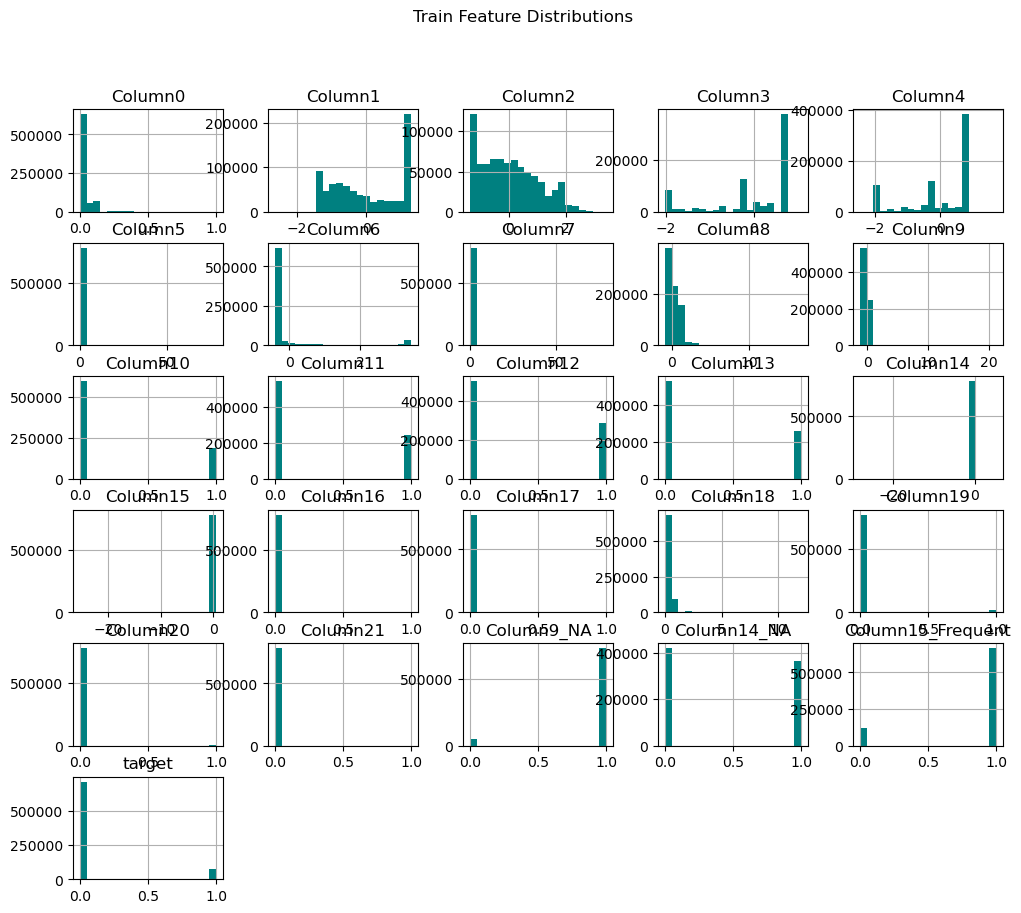

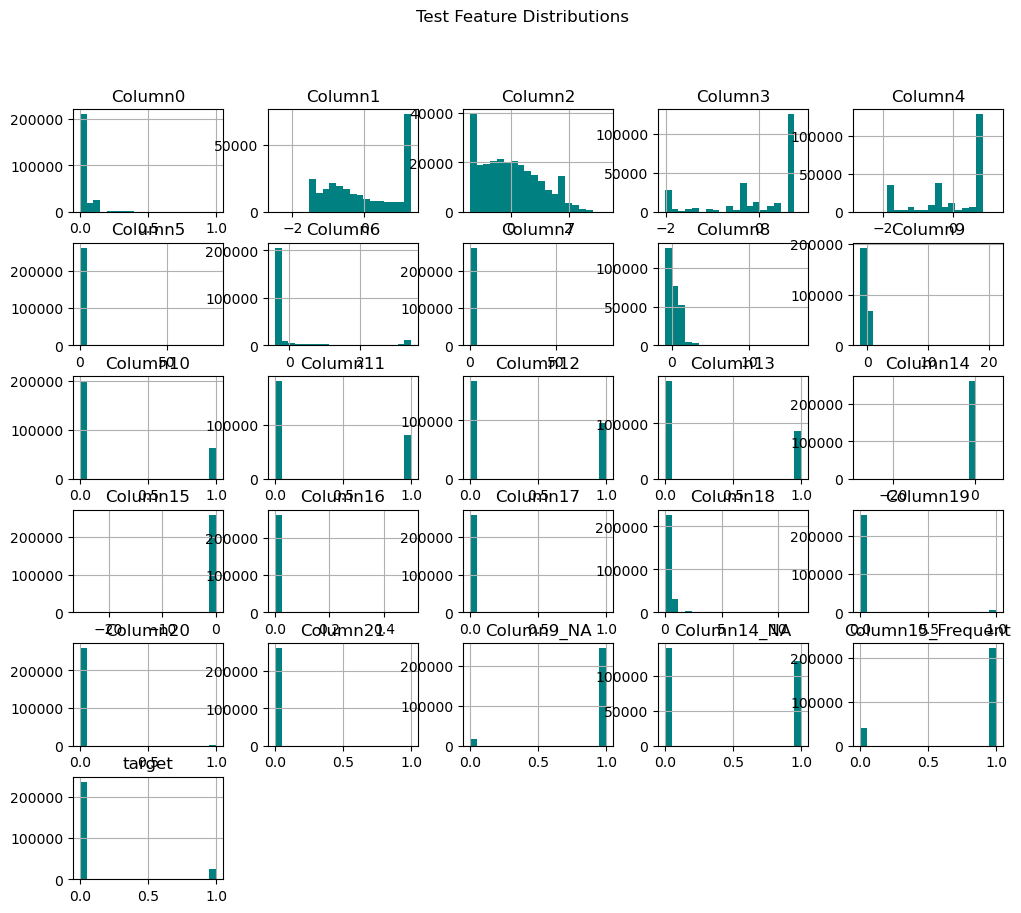

In [28]:
# Train: Visualize the distribution of the target labels in train dataset
plt.figure(figsize=(6,4))
combined_train['target'].value_counts().plot(kind='bar', color=['skyblue', 'salmon'])
plt.title('Distribution of Training Labels')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.show()

# Test: Visualize the distribution of the target labels in test dataset
plt.figure(figsize=(6,4))
combined_test['target'].value_counts().plot(kind='bar', color=['skyblue', 'salmon'])
plt.title('Distribution of Test Labels')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.show()

# Train: Visualizing the correlation matrix for numerical features (before handling missing values)
plt.figure(figsize=(12,8))
corr_matrix = combined_train.corr()
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', linewidths=0.5)
plt.title("Train: Feature Correlation Matrix")
plt.show()

# Test: Visualizing the correlation matrix for numerical features (before handling missing values)
plt.figure(figsize=(12,8))
corr_matrix = combined_test.corr()
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', linewidths=0.5)
plt.title("Test: Feature Correlation Matrix")
plt.show()


# Train: Visualize the distribution of each feature using histograms
combined_train.hist(figsize=(12,10), bins=20, color='teal')
plt.suptitle('Train Feature Distributions')
plt.show()

# Test: Visualize the distribution of each feature using histograms
combined_test.hist(figsize=(12,10), bins=20, color='teal')
plt.suptitle('Test Feature Distributions')
plt.show()

# 4. Model 0 (Robust to class 0) (To filter out the easy examples if needed)

## 4.1. Build and Train the model

In [33]:
model_2 = Sequential()

# Input layer
model_2.add(Input(shape=(X_train.shape[1],)))

model_2.add(Dense(256, activation='relu', kernel_regularizer=l2(0.001)))
model_2.add(Dropout(0.4))

model_2.add(Dense(128, activation='relu', kernel_regularizer=l2(0.001)))
model_2.add(Dropout(0.4))  # Regularization

model_2.add(Dense(64, activation='relu', kernel_regularizer=l2(0.001)))
model_2.add(BatchNormalization())
model_2.add(Dropout(0.4))

model_2.add(Dense(32, activation='relu', kernel_regularizer=l2(0.001)))

# Output layer
model_2.add(Dense(1, activation='sigmoid'))

# Compile model
optimizer = Adam(learning_rate=0.001)
model_2.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy', 'Precision', 'Recall', 'AUC'])

2024-09-23 18:47:50.102283: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 6719 MB memory:  -> device: 0, name: NVIDIA T1000 8GB, pci bus id: 0000:af:00.0, compute capability: 7.5


In [34]:
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(Y_train), y=Y_train)
class_weights = dict(enumerate(class_weights))
print(class_weights)

{0: 0.5520552664885389, 1: 5.302588035065444}


In [ ]:
# Run Tensorboard to visualize the training progress
%tensorboard --logdir {'tf_logs/model_nn_robust_class_0'}

In [35]:
tensorboard_callback_model_2 = tf.keras.callbacks.TensorBoard(log_dir='tf_logs/model_nn_robust_class_0', histogram_freq=1)
lr_scheduler_model_2 = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

model_2.fit(X_train, Y_train, 
          epochs=15, 
          batch_size=128, 
          validation_data=(X_test, Y_test), 
          callbacks=[tensorboard_callback_model_2, lr_scheduler_model_2],
          class_weight=class_weights
         )

Epoch 1/15


I0000 00:00:1727097491.288080  181185 service.cc:146] XLA service 0x7facd800e7f0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1727097491.288171  181185 service.cc:154]   StreamExecutor device (0): NVIDIA T1000 8GB, Compute Capability 7.5
2024-09-23 18:48:11.427786: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-09-23 18:48:11.760428: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907


   9/6134 ━━━━━━━━━━━━━━━━━━━━ 42s 7ms/step - AUC: 0.5683 - Precision: 0.1153 - Recall: 0.4547 - accuracy: 0.6254 - loss: 1.1068    

I0000 00:00:1727097495.730674  181185 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


6134/6134 ━━━━━━━━━━━━━━━━━━━━ 40s 5ms/step - AUC: 0.9829 - Precision: 0.6648 - Recall: 0.9826 - accuracy: 0.9485 - loss: 0.2616 - val_AUC: 0.9916 - val_Precision: 0.7177 - val_Recall: 0.9984 - val_accuracy: 0.9628 - val_loss: 0.1265 - learning_rate: 0.0010
Epoch 2/15
6134/6134 ━━━━━━━━━━━━━━━━━━━━ 24s 4ms/step - AUC: 0.9901 - Precision: 0.7211 - Recall: 0.9985 - accuracy: 0.9632 - loss: 0.0915 - val_AUC: 0.9919 - val_Precision: 0.7222 - val_Recall: 0.9983 - val_accuracy: 0.9636 - val_loss: 0.1058 - learning_rate: 0.0010
Epoch 3/15
6134/6134 ━━━━━━━━━━━━━━━━━━━━ 25s 4ms/step - AUC: 0.9904 - Precision: 0.7171 - Recall: 0.9981 - accuracy: 0.9626 - loss: 0.0888 - val_AUC: 0.9921 - val_Precision: 0.7248 - val_Recall: 0.9989 - val_accuracy: 0.9641 - val_loss: 0.1034 - learning_rate: 0.0010
Epoch 4/15
6134/6134 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - AUC: 0.9905 - Precision: 0.7240 - Recall: 0.9980 - accuracy: 0.9638 - loss: 0.0868 - val_AUC: 0.9920 - val_Precision: 0.7246 - val_Recall: 0.9998 -

## 4.2. Save the model

In [36]:
model_2.save('tf_models/model_nn_robust_class_0.keras') # For newer version of Tensorflow
model_2.save('tf_models/model_nn_robust_class_0.h5') # For older version of Tensorflow

## 4.3. Load the model (optional)
If already trained, load that model

In [4]:
model_0 = tf.keras.models.load_model('tf_models/model_nn_robust_class_0.keras')

2024-10-03 21:25:55.915910: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 6717 MB memory:  -> device: 0, name: NVIDIA T1000 8GB, pci bus id: 0000:af:00.0, compute capability: 7.5


## 4.4. Test the Model

In [5]:
Y_pred_prob_0 = model_0.predict(X_test)

I0000 00:00:1727970960.064117  179698 service.cc:146] XLA service 0x7f3e8c013650 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1727970960.064190  179698 service.cc:154]   StreamExecutor device (0): NVIDIA T1000 8GB, Compute Capability 7.5
2024-10-03 21:26:00.081741: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-10-03 21:26:00.177039: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907


 137/8179 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step    

I0000 00:00:1727970960.786068  179698 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


8179/8179 ━━━━━━━━━━━━━━━━━━━━ 10s 1ms/step


In [6]:
Y_pred_0 = (Y_pred_prob_0 > 0.4).astype(int).flatten()

Model 0 Accuracy: 96.39%

Confusion Matrix:
[[227597   9437]
 [     2  24676]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.96      0.98    237034
           1       0.72      1.00      0.84     24678

    accuracy                           0.96    261712
   macro avg       0.86      0.98      0.91    261712
weighted avg       0.97      0.96      0.97    261712



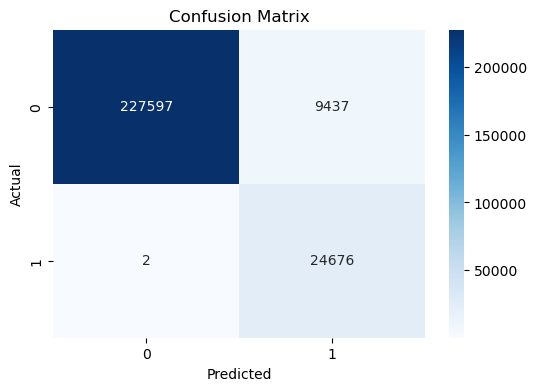

Precision: 0.72
Recall: 1.00
F1-Score: 0.84
ROC-AUC: 0.98


In [7]:
# Evaluate the model
accuracy_0 = accuracy_score(Y_test, Y_pred_0)
print(f"Model 0 Accuracy: {accuracy_0 * 100:.2f}%")

# Confusion matrix
cm_0 = confusion_matrix(Y_test, Y_pred_0)
print("\nConfusion Matrix:")
print(cm_0)

# Classification report
print("\nClassification Report:")
print(classification_report(Y_test, Y_pred_0))

# Visualizing the confusion matrix
plt.figure(figsize=(6,4))
sns.heatmap(cm_0, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# Precision, Recall, F1-Score
precision_0 = precision_score(Y_test, Y_pred_0)
recall_0 = recall_score(Y_test, Y_pred_0)
f1_0 = f1_score(Y_test, Y_pred_0)
roc_auc_0 = roc_auc_score(Y_test, Y_pred_0)

print(f"Precision: {precision_0:.2f}")
print(f"Recall: {recall_0:.2f}")
print(f"F1-Score: {f1_0:.2f}")
print(f"ROC-AUC: {roc_auc_0:.2f}")

## 4.5. Filter Out the Class 1 and 0 samples

In [8]:
# Get predictions from model_0
Y_pred_prob_0_train = model_0.predict(X_train)
Y_pred_prob_0_test = model_0.predict(X_test)

24536/24536 ━━━━━━━━━━━━━━━━━━━━ 21s 858us/step
8179/8179 ━━━━━━━━━━━━━━━━━━━━ 8s 997us/step


In [9]:
Y_pred_0_train = (Y_pred_prob_0_train > 0.4).astype(int).flatten()
Y_pred_0_test = (Y_pred_prob_0_test > 0.4).astype(int).flatten()

In [10]:
# Set aside class 0 predictions and create subsets

# For X_train
class_0_indices_train = np.where(Y_pred_0_train == 0)[0]  # Indices where class 0 is predicted
class_1_indices_train = np.where(Y_pred_0_train != 0)[0]  # Indices where class 1 or others are predicted

# Use iloc to select rows by index for X_train and y_train
X_train_filter_1 = X_train.iloc[class_1_indices_train]  # Subset of rows not predicted as class 0
Y_train_filter_1 = Y_train.iloc[class_1_indices_train]

# For X_test
class_0_indices_test = np.where(Y_pred_0_test == 0)[0]
class_1_indices_test = np.where(Y_pred_0_test != 0)[0]

# Subset for X_test and y_test
X_test_filter_1 = X_test.iloc[class_1_indices_test]
Y_test_filter_1 = Y_test.iloc[class_1_indices_test]

# 5. DML Model

In [20]:
# Create pairs of data (Siamese Network requires pairs of samples)
def create_pairs(X, Y):
    pairs, labels = [], []
    num_classes = 2  # Binary classification (0 and 1)
    
    # Separate data into two sets based on class
    X_class_0 = X[Y == 0]
    X_class_1 = X[Y == 1]

    # Generate pairs
    for idx in range(len(X)):
        if Y[idx] == 0:
            pos_idx = np.random.randint(0, len(X_class_0))
            neg_idx = np.random.randint(0, len(X_class_1))
            pairs.append([X[idx], X_class_0[pos_idx]])
            pairs.append([X[idx], X_class_1[neg_idx]])
            labels.append(1)  # Same class
            labels.append(0)  # Different class
        else:
            pos_idx = np.random.randint(0, len(X_class_1))
            neg_idx = np.random.randint(0, len(X_class_0))
            pairs.append([X[idx], X_class_1[pos_idx]])
            pairs.append([X[idx], X_class_0[neg_idx]])
            labels.append(1)
            labels.append(0)
    
    return np.array(pairs), np.array(labels)

In [428]:
pairs_train, labels_train = create_pairs(X_train.to_numpy(), Y_train.to_numpy())
pairs_test, labels_test = create_pairs(X_test.to_numpy(), Y_test.to_numpy())

In [429]:
# Build the embedding model
def create_embedding_network(input_shape):
    input = Input(shape=input_shape)
    x = Dense(512, activation='relu')(input)
    x = Dense(256, activation='relu')(x)
    x = Dense(128, activation='relu')(x)
    x = Dense(64, activation='relu')(x)
    return tf.keras.models.Model(input, x)

def euclidean_distance(vects):
    x, y = vects
    sum_square = tf.reduce_sum(tf.square(x - y), axis=1, keepdims=True)
    return tf.sqrt(tf.maximum(sum_square, tf.keras.backend.epsilon()))

def eucl_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)

# Siamese Network
def create_siamese_network(input_shape):
    embedding_network = create_embedding_network(input_shape)
    
    input_1 = Input(shape=input_shape)
    input_2 = Input(shape=input_shape)
    
    embedding_1 = embedding_network(input_1)
    embedding_2 = embedding_network(input_2)
    
    # L2 distance between embeddings
    #l2_distance = Lambda(lambda tensors: tf.norm(tensors[0] - tensors[1], axis=1))([embedding_1, embedding_2])

    # Reshape to match Dense layer's expected input (batch_size, 1)
    #l2_distance = tf.keras.layers.Reshape((1,))(l2_distance)
    
    #output = Dense(1, activation="sigmoid")(l2_distance)
    output = Lambda(euclidean_distance, name="output_layer", output_shape=eucl_dist_output_shape)([embedding_1, embedding_2])

    
    siamese_net = tf.keras.models.Model(inputs=[input_1, input_2], outputs=output)
    return siamese_net

In [430]:
# Custom contrastive loss function
def contrastive_loss(y_true, y_pred):
    margin = 1.0  # Margin for dissimilar pairs
    square_pred = tf.square(y_pred)
    margin_square = tf.square(tf.maximum(margin - y_pred, 0))
    return tf.reduce_mean(y_true * square_pred + (1 - y_true) * margin_square)

In [431]:
# Mean distance metric for contrastive learning
def mean_distance(y_true, y_pred):
    return tf.reduce_mean(y_pred)

In [432]:
# Compile the model
siamese_net = create_siamese_network(X_train.shape[1:])
siamese_net.compile(optimizer=tf.keras.optimizers.Adam(), loss=contrastive_loss)

In [433]:
# Split pairs into two input arrays
pairs_train_1 = pairs_train[:, 0]
pairs_train_2 = pairs_train[:, 1]

pairs_test_1 = pairs_test[:, 0]
pairs_test_2 = pairs_test[:, 1]

In [434]:
print(pairs_train.shape)
print(labels_train.shape)

(1570266, 2, 25)
(1570266,)


In [435]:
# Train the model
siamese_net.fit([pairs_train_1, pairs_train_2], labels_train, batch_size=268, epochs=10, validation_data=([pairs_test_1, pairs_test_2], labels_test))

Epoch 1/10
5860/5860 ━━━━━━━━━━━━━━━━━━━━ 22s 3ms/step - loss: 0.0419 - val_loss: 0.0378
Epoch 2/10
5860/5860 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step - loss: 0.0364 - val_loss: 0.0371
Epoch 3/10
5860/5860 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - loss: 0.0357 - val_loss: 0.0365
Epoch 4/10
5860/5860 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - loss: 0.0353 - val_loss: 0.0371
Epoch 5/10
5860/5860 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - loss: 0.0345 - val_loss: 0.0371
Epoch 6/10
5860/5860 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step - loss: 0.0340 - val_loss: 0.0373
Epoch 7/10
5860/5860 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step - loss: 0.0333 - val_loss: 0.0380
Epoch 8/10
5860/5860 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - loss: 0.0327 - val_loss: 0.0385
Epoch 9/10
5860/5860 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step - loss: 0.0324 - val_loss: 0.0392
Epoch 10/10
5860/5860 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step - loss: 0.0316 - val_loss: 0.0399


In [436]:
# Project the samples into the embedding space for classification
embedding_model = create_embedding_network(X_train.shape[1:])
embedding_model.set_weights(siamese_net.layers[2].get_weights())  # Copy weights from the trained embedding network

# Get embeddings
train_embeddings = embedding_model.predict(X_train_filter_1)
test_embeddings = embedding_model.predict(X_test_filter_1)

3191/3191 ━━━━━━━━━━━━━━━━━━━━ 3s 820us/step
1067/1067 ━━━━━━━━━━━━━━━━━━━━ 1s 849us/step


In [437]:
print(train_embeddings.shape)
print(X_train_filter_1.shape)

(102082, 64)
(102082, 25)


In [438]:
X_train_comb = np.column_stack((train_embeddings, X_train_filter_1))
X_test_comb = np.column_stack((test_embeddings, X_test_filter_1))

X_train_comb = train_embeddings
X_test_comb = test_embeddings

In [439]:
print(X_train_comb.shape)
print(Y_train_filter_1.shape)

(102082, 64)
(102082,)


In [440]:
model_classif = XGBClassifier(scale_pos_weight=(1/1), random_state=42, n_estimators=100)
model_classif.fit(X_train_comb, Y_train_filter_1)
#model_classif.fit(X_train, Y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

Model 1 Accuracy: 80.75%

Confusion Matrix:
[[ 4874  4563]
 [ 2004 22672]]

Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.52      0.60      9437
           1       0.83      0.92      0.87     24676

    accuracy                           0.81     34113
   macro avg       0.77      0.72      0.74     34113
weighted avg       0.80      0.81      0.80     34113



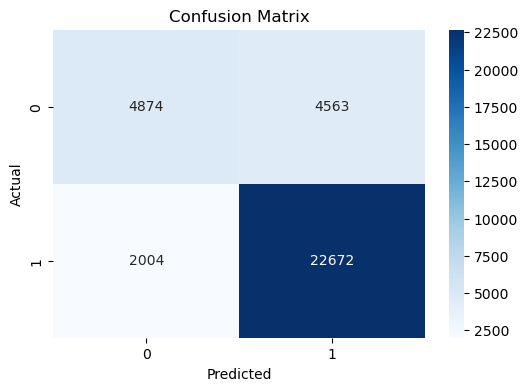

In [441]:
# Make predictions
Y_pred_1 = model_classif.predict(X_test_comb)

# Evaluate the model
accuracy_1 = accuracy_score(Y_test_filter_1, Y_pred_1)
print(f"Model 1 Accuracy: {accuracy_1 * 100:.2f}%")

# Confusion matrix
cm_1 = confusion_matrix(Y_test_filter_1, Y_pred_1)
print("\nConfusion Matrix:")
print(cm_1)

# Classification report for more detailed evaluation
print("\nClassification Report:")
print(classification_report(Y_test_filter_1, Y_pred_1))

# Visualizing the confusion matrix
plt.figure(figsize=(6,4))
sns.heatmap(cm_1, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [399]:
# Step 4: Combine predictions preserving the original order
final_pred_train = np.zeros_like(Y_pred_0_train)
final_pred_test = np.zeros_like(Y_pred_0_test)

# Set class 0 predictions from model_2
final_pred_train[class_0_indices_train] = 0
final_pred_test[class_0_indices_test] = 0

final_pred_train[class_1_indices_train] = model_classif.predict(X_train_comb)
final_pred_test[class_1_indices_test] = model_classif.predict(X_test_comb)

Model 1 Accuracy: 97.54%

Confusion Matrix:
[[232506   4528]
 [  1913  22765]]

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.98      0.99    237034
           1       0.83      0.92      0.88     24678

    accuracy                           0.98    261712
   macro avg       0.91      0.95      0.93    261712
weighted avg       0.98      0.98      0.98    261712



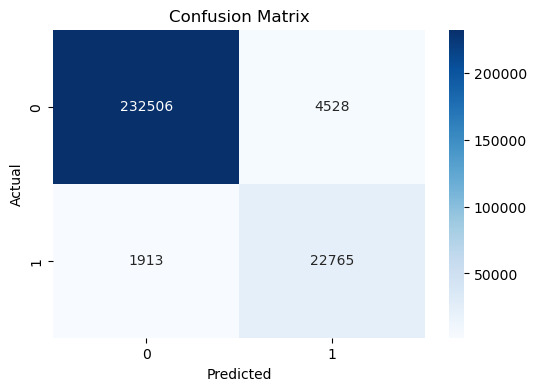

In [400]:
# Make predictions
Y_pred_1 = final_pred_test

# Evaluate the model
accuracy_1 = accuracy_score(Y_test, Y_pred_1)
print(f"Model 1 Accuracy: {accuracy_1 * 100:.2f}%")

# Confusion matrix
cm_1 = confusion_matrix(Y_test, Y_pred_1)
print("\nConfusion Matrix:")
print(cm_1)

# Classification report for more detailed evaluation
print("\nClassification Report:")
print(classification_report(Y_test, Y_pred_1))

# Visualizing the confusion matrix
plt.figure(figsize=(6,4))
sns.heatmap(cm_1, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [30]:
# Save model for future predictions
model_1.save_model('tf_models/model_xgb_robust_class_1.json')